<ipython-input-1-8388e77d168c>:88: RuntimeWarning: invalid value encountered in log10
  M = -2.5*np.log10(A) - C + random.gauss(0, mean_std) # bei beiden Gauss-Rauschen machen


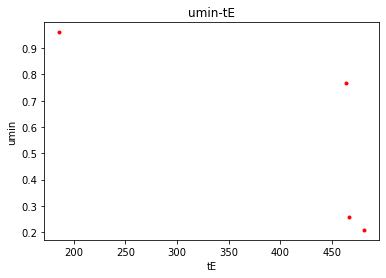

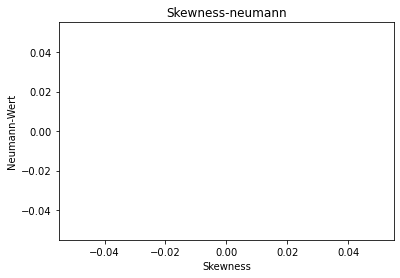

Noch nicht verstandener scheinbarer Fehlversuch. Nochmal ausführen bis es klappt.


In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm, skew, kurtosis
from scipy.optimize import curve_fit as fit
import random

"""
Der Datensatz generiert Lichtkurvenliste der Anzahl LCamount. Jede Liste enthält 7 Einträge:
Index 0: id
1: Liste der Magnitudenwerte
2: Liste der Zeitpunkte
3: Falls ML-Event: umin-Wert
   sonst: None
4: Falls ML-Event: tE-Wert (Dauer des ML-Events)
   sonst: None
5: Skewness
6: Neumann-Wert
"""

# VALUES
probability = 1 # pro x (Probability) LC hat es ca. i ML-Event
magpointamount_min = 30 # Mindestanzahl Messungen
t0 = 0 # Zeitpunkt max. Helligkeit
surveylength = 500 # wie lange gesamte Messung dauerte = maximale Eventdauer
mean_skew = -0.22994225279524635  #Mittelwert von 2 fields 
mean_std = 0.15856555  # Mittelwert von 2 fields 
mean_mag = 20.421268  # Mittelwert von 2 fields 
mean_luminosity = 10**(mean_mag/(-2.5)) # convert magnitude-mean to luminosity-value for multiplication by amplification factor 
mean_neumann = 1.5 # circa
C = 0 # parameter for magnitude-calculation
LCamount = 10 # x LCs will be generated
lost = 0
trap = 0
found = 0

# LISTS
lightc_lst = [0 for i in range(LCamount)] # stellt synthetischen Datensatz dar -> pro LC: Liste wie [Index (-> Object-ID), Magnitudenwerte, Zeitpunkte] 
detect_lst_binary = np.zeros(LCamount) # Array gefilterter ML-Events, np.zeros(x) macht Liste mit x Nullen
truetruth_lst_binary = np.zeros(LCamount) # Array mit tatsächlichen ML-Events -> muss Liste sein, da np.array keine arrays speichern kann aber kein Problem, da bei ZTF kein lclist erzeugt werden muss
lightc_lst_filtered = [] # Index (wie object ID) wird in Liste eingefügt -> am Schluss gezählt, ob alle Kriterien erfüllt
skew_lst = np.zeros(LCamount) # Skewness-Werte alles LC
std_lst = np.zeros(LCamount) # Standardabw-Werte alles LC
neumann_lst = np.zeros(LCamount)
umin_lost = []
tE_lost = []
umin_found = []
tE_found = []
filtered_lst = []
skew_found = []
skew_lost = []
neumann_found = []
neumann_lost = []


# FUNCTIONS
def theo(t, umin, tE): #theoretische ML-Funktion
    t_0 = 0
    u = np.sqrt(umin**2 + ((t-t_0)/tE)**2)
    A = (u**2 + 2) / (u*np.sqrt(u**2 + 4)) 
    M = -2.5*np.log10(A) 
    return M

def neumann(array):
    neumann_lst = np.zeros(len(array))
    std = np.std(array)
    for i in range(1, len(array)):
        neumann_lst[i] = ((array[i] - array[i-1])**2)/((len(array)-1)*(std**2))
    n = np.sum(neumann_lst)
    return n


# SYNTHETIC LC GENERATOR -> Produktion künstlicher LC -> random ML-Events oder nicht
for i in range(LCamount):   
    ML_yesorno = random.randint(0, probability) #Wahrscheinlichkeit von 1/40
    magpointamount = random.randint(magpointamount_min, 100)
    if ML_yesorno == 1: #falls Microlensing-Event
        truetruth_lst_binary[i] = 1 #Nullen-Array an x-ter Stelle mit 1 ersetzt -> ML-Event
        # freie Parameter hängen von t ab -> verändern sich mit der Zeit -> Körper bewegen sich
        umin = random.random()
        tE = random.randint(1, surveylength) # Zeitdauer, um Einstein-Radius zurückzulegen
        t = np.array(
            random.randint(-(1/2)*surveylength, (1/2)*surveylength)
            for 
            x in range(magpointamount)
        )
        np.ndarray.sort(t)
        mag = np.array(
            theo(t[x], umin, tE)  + random.gauss(-0.2, 0.2) 
            for 
            x in range(magpointamount)
        )
        lightc_lst[i] = np.array([i, mag, t, umin, tE, lc_skew_value, lc_neumann_value], dtype = object)
        # print("umin: ", umin, "tE: ", tE, "skew: ", skew(mag), "std: ", np.std(mag))
        # print("fit_umin: ", fit(theo, t, mag)[0][0], "fit_tE: ", fit(theo, t, mag)[0][1])
        # plt.figure() #make coordinate system
        # plt.plot(t, mag,".", color = "red")#t,mag = lists! -> A(t)+0.2*random -> adds random number to whole list -> for loop to handle each value separately!
        # #plt.plot(t, th(t, fit(th, t, mag)[0][0], fit(th, t, mag)[0][1]))

    else: 
        t = np.array(
            random.randint(-(1/2)*surveylength, (1/2)*surveylength)
            for x in range(magpointamount)
        )
        np.ndarray.sort(t)
        for x in range(magpointamount):
            M = mean_mag - C + random.gauss(0, mean_std)
        mag = np.array(
            mean_mag - C + random.gauss(0, mean_std)
            for x in range(magpointamount)
        )
            lc_skew_value = skew(mag)
            lc_neumann_value = neumann(mag)
        lightc_lst[i] = np.array([i, mag, t, None, None, lc_skew_value, lc_neumann_value], dtype = object)
        # plt.figure() # make coordinate system
        # plt.plot(t, mag,".", color = "red")#t,a = lists! -> A(t)+0.2*random -> adds random number to whole list -> for loop to handle each value separately!

# SKEWNESS-NEUMANN-VALUE-CALCULATION
for i in range(LCamount):
    skew_lst[i] = skew(lightc_lst[i][1])
    neumann_lst[i] = neumann(lightc_lst[i][1])

# FILTER
for i in range(LCamount):
    if skew_lst[i] - 0.5 < -neumann_lst[i]:
        detect_lst_binary[i] = 1
        lightc_lst_filtered.append(lightc_lst[i]) # lclist[i] = numpy-array  
    else:
        detect_lst_binary[i] = 0


for i in range(LCamount):
    if ((truetruth_lst_binary[i] == 1) and (detect_lst_binary[i] == 1)):
        found += 1
        umin_found.append(lightc_lst[i][3])
        tE_found.append(lightc_lst[i][4])
        print(lightc_lst[i][5])
        skew_found.append[lightc_lst[i][5]]
        neumann_found.append[lightc_lst[i][6]]
        filtered_lst.append(lightc_lst[i])
    if ((truetruth_lst_binary[i] == 1) and (detect_lst_binary[i] == 0)):
        lost += 1
        umin_lost.append(lightc_lst[i][3])
        tE_lost.append(lightc_lst[i][4])
        skew_lost.append(lightc_lst[i][5])
        neumann_lost.append(lightc_lst[i][6])
    if ((truetruth_lst_binary[i] == 0) and (detect_lst_binary[i] == 1)):
        trap += 1


# umin-tE-Diagramm:
plt.figure()
plt.plot(tE_lost, umin_lost, ".", color = "red")
plt.plot(tE_found, umin_found, ".", color = "green")
plt.xlabel("tE")
plt.ylabel("umin")
plt.title("umin-tE")
plt.show()

# skewness-neumann-diagramm
plt.figure()
plt.plot(skew_found, neumann_found, ".", color = "green")
plt.plot(skew_lost, neumann_lost, ".", color = "red")
plt.xlabel("Skewness")
plt.ylabel("Neumann-Wert")
plt.title("Skewness-neumann")
plt.show()

# print("TEST (-> Fehlversuch falls 0): ", np.count_nonzero(truthlst == 1))#?????
if np.count_nonzero(detect_lst_binary == 1) != 0: #wenn kein sog "Fehlversuch"
    print("verlorene ML: ", lost)
    print("scheinbare ML: ", trap)
    print("gefundene ML: ", found)
    #print(truetruth_lst_binary)
    #print(detect_lst_binary)
else:
    print("Noch nicht verstandener scheinbarer Fehlversuch. Nochmal ausführen bis es klappt.")

# FITTING

filteredLCamount = len(lightc_lst_filtered)
fittedlst = []
maxcov = 1 #maximale Kovarianz -> ?

for i in range(filteredLCamount):
    id = lightc_lst_filtered[i][0] 
    mag = lightc_lst_filtered[i][1] 
    t = lightc_lst_filtered[i][2] 
    try: #try-except-thing causes loop to continue when error occurs
        fitted_params, param_covariance = fit(theo, t, mag, p0 = [0.5, 150]) #input theo=Funktion, die gefittet werden soll, t=unabhängige Variable, a=Messwerte, p0 = initial guesses
        umin_fit = fitted_params[0]
        tE_fit = fitted_params[1]
        if (0.0 < umin_fit <= 1.0) and (0 < tE_fit <= 250):
            if (param_covariance[0] < maxcov) and (param_covariance[1] < maxcov):
                fittedlst.append([id, fitted_params, param_covariance])
                print("*** Parameters:", fitted_params,"*** Covariance:", param_covariance, "***")

    except:
        pass
